## Data Preprocessing

In [ ]:
import pandas
import matplotlib.pyplot as plt

In [247]:
df = pandas.read_csv("data/train-metadata.csv")
df.head()

/var/folders/8v/3hj81gys6dgdw401b74kwjrr0000gn/T/ipykernel_11162/3460426017.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv("data/train-metadata.csv")


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [248]:
df["target"].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [249]:
malignant = df[df["target"] == 1]
malignant.shape

(393, 55)

In [250]:
benign = df[df["target"] == 0]
benign.shape

(400666, 55)

In [251]:
SEED = 1234
BENIGN_SIZE = 5000 # Limits benign samples for data balancing
benign_limited = benign.sample(BENIGN_SIZE)
benign_limited.shape

(5000, 55)

In [252]:
merged_balanced = pandas.concat([benign_limited, malignant])
merged_balanced.shape

(5393, 55)

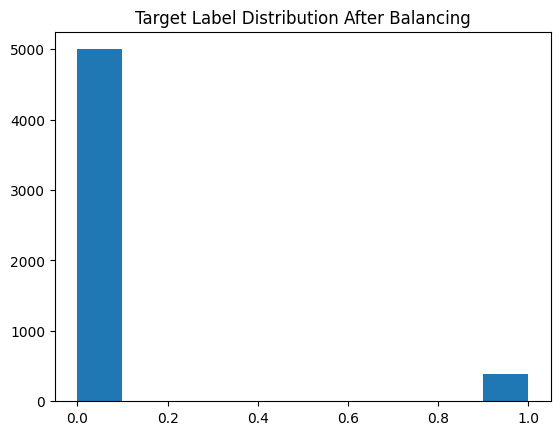

In [253]:
plt.hist(merged_balanced["target"])
plt.title("Target Label Distribution After Balancing")
plt.show()

## Data Augmentation

In [254]:
import cv2
from tqdm import tqdm

def adjust_brightness_contrast(input_path: str, output_path: str):
    if input_path == output_path:
        raise ValueError("output path overwrites input path")
    
    try:
        img = cv2.imread(input_path)

        if img is None:
            raise ValueError("Failed to load image. Check the input path.")

        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l_channel, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a, b))

        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        cv2.imwrite(output_path, enhanced_img)

    except Exception as e:
        print(f"Error adjusting brightness/contrast: {e}")


def flip_image(input_path: str, output_path: str, mode: str = 'horizontal'):
    if input_path == output_path:
        raise ValueError("output path overwrites input path")
    
    try:
        image = cv2.imread(input_path)
        if image is None:
            raise ValueError("Could not load image. Check the input path.")

        flip_codes = {
            'horizontal': 1,
            'vertical': 0,
            'both': -1
        }

        if mode not in flip_codes:
            raise ValueError("Invalid flip mode. Choose from 'horizontal', 'vertical', or 'both'.")

        flipped = cv2.flip(image, flip_codes[mode])
        cv2.imwrite(output_path, flipped)

    except Exception as e:
        print(f"Error flipping image: {e}")


In [255]:
path_format = "data/image/{}.jpg"

transformed_rows = []

for _, row in tqdm(malignant.iterrows(), total=len(malignant), desc="Transforming images"):
    og_src = row["isic_id"]
    contrasted_output_name = og_src + "_contrasted"
    flipped_output_name = og_src + "_flipped"
    
    input_path = path_format.format(og_src)
    contrasted_output_path = path_format.format(contrasted_output_name)
    flipped_output_path = path_format.format(flipped_output_name)
    
    adjust_brightness_contrast(input_path, contrasted_output_path)
    flip_image(input_path, flipped_output_path)
    
    row_copy = row.copy()
    row_copy["isic_id"] = contrasted_output_name
    transformed_rows.append(row_copy.to_dict())    
    
    row_copy = row.copy()
    row_copy["isic_id"] = flipped_output_name
    transformed_rows.append(row_copy.to_dict())
    

transformed_df = pandas.DataFrame(transformed_rows)
merged_balanced_augmented = pandas.concat([transformed_df, merged_balanced])
merged_balanced_augmented["image_path"] = [path_format.format(row["isic_id"]) for (_, row) in merged_balanced_augmented.iterrows()]
merged_balanced["image_path"] = [path_format.format(row["isic_id"]) for (_, row) in merged_balanced.iterrows()]
merged_balanced_augmented.shape
    

Transforming images: 100%|██████████| 393/393 [00:00<00:00, 971.59it/s] 


(6179, 56)

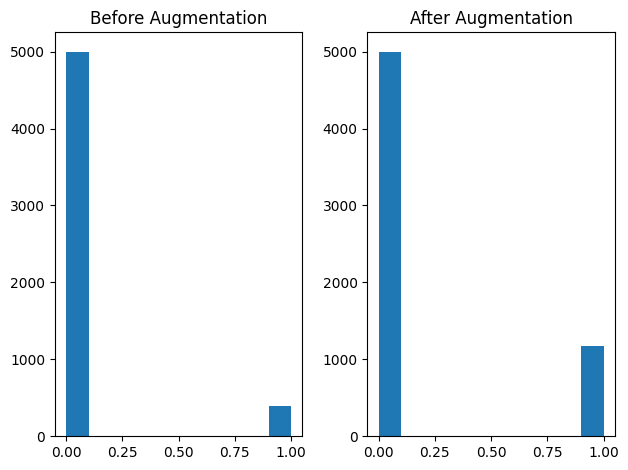

In [256]:
fig, axes = plt.subplots(1, 2, )
axes[0].hist(merged_balanced["target"])
axes[0].set_title("Before Augmentation")
axes[1].hist(merged_balanced_augmented["target"])
axes[1].set_title("After Augmentation")
fig.tight_layout()

## Training

In [257]:
import random
random.seed(SEED)

test_ratio = 0.2

def train_test_split(df, test_size=0.2, random_state=None):
    test_df = df.sample(frac=test_size, random_state=random_state)
    train_df = df.drop(test_df.index)
    return train_df, test_df

train_df, test_df = train_test_split(merged_balanced, test_size=test_ratio, random_state=SEED)
train_df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,image_path
166319,ISIC_4197835,0,IP_8506963,75.0,female,head/neck,2.77,TBP tile: close-up,3D: XP,23.110520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,data/image/ISIC_4197835.jpg
311744,ISIC_7793666,0,IP_5001333,60.0,male,lower extremity,2.60,TBP tile: close-up,3D: XP,20.294842,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,data/image/ISIC_7793666.jpg
265885,ISIC_6664144,0,IP_4439138,60.0,male,anterior torso,2.58,TBP tile: close-up,3D: white,22.697863,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.976748,data/image/ISIC_6664144.jpg
293489,ISIC_7344576,0,IP_9293142,55.0,female,lower extremity,3.20,TBP tile: close-up,3D: XP,15.292420,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,data/image/ISIC_7344576.jpg
217391,ISIC_5463619,0,IP_5714646,40.0,male,posterior torso,5.28,TBP tile: close-up,3D: XP,18.585660,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999630,data/image/ISIC_5463619.jpg


In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

torch.manual_seed(SEED)

In [259]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        
        if len(image_paths) != len(labels):
            raise ValueError(f"Value mismatch between images ({len(image_paths)}) and labels ({len(labels)})")
        
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = float(self.labels[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

train_dataset = ImageDataset(train_df["image_path"].to_list(), train_df["target"].to_list())
test_dataset = ImageDataset(test_df["image_path"].to_list(), test_df["target"].to_list())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [260]:
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (16, 32, 32)

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32, 16, 16)
            # 
            # nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),  # (64, 8, 8)
            # 
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(2),  # (128, 4, 4)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),  # 2048 → 128
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x.squeeze()


In [261]:
EPOCH = 10

# Model, Loss, Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BinaryCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCH):
    model.train()
    train_loss = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        train_total += batch_size

    model.eval()
    eval_loss = 0
    eval_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            eval_loss += loss.item() * batch_size
            eval_total += batch_size

    avg_train_loss = train_loss / train_total
    avg_eval_loss = eval_loss / eval_total

    print(f"EPOCH: {epoch}\tEval Loss: {avg_eval_loss:.4f}\tTrain Loss: {avg_train_loss:.4f}")


EPOCH: 0	Eval Loss: 0.2475	Train Loss: 0.2763
EPOCH: 1	Eval Loss: 0.2392	Train Loss: 0.2646
EPOCH: 2	Eval Loss: 0.2295	Train Loss: 0.2601
EPOCH: 3	Eval Loss: 0.1981	Train Loss: 0.2358
EPOCH: 4	Eval Loss: 0.1819	Train Loss: 0.2211
EPOCH: 5	Eval Loss: 0.1915	Train Loss: 0.2259
EPOCH: 6	Eval Loss: 0.1725	Train Loss: 0.2212
EPOCH: 7	Eval Loss: 0.1936	Train Loss: 0.2020
EPOCH: 8	Eval Loss: 0.1635	Train Loss: 0.2056
EPOCH: 9	Eval Loss: 0.1715	Train Loss: 0.1979


In [261]:
def calculate_accuracy(outputs, labels):
    total_match = sum(i == j for i, j in zip(outputs, labels))
    return total_match / len(outputs)

total_outputs = []
total_labels = []
 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_outputs.extend(outputs)
        total_labels.extend(labels)
        
calculate_accuracy(total_outputs, total_labels)

    

## Saving Model

In [262]:
save_path = "cnn_weights.pth"
torch.save(model.state_dict(), save_path)
print(f"File save successful: {os.path.exists(save_path)}")

File save successful: True
